In [1]:
import logging
import math
import os

import matplotlib.dates as mdates
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from msig import Motif, NullModel

params = {"legend.fontsize": "xx-large", "axes.labelsize": 20}
pylab.rcParams.update(params)
logging.basicConfig(level=logging.INFO)

In [2]:
# read the data
data = pd.read_csv("../data/activityrecognition/S008.csv")
# change timestamp from float to datetime
data["timestamp"] = pd.to_datetime(data["timestamp"])
data = data.set_index("timestamp")
# resample the data to 4 per 1 second
sr = 4
data = data.resample("0.25s").last().ffill()
# replace labels coding
data["label"] = data["label"].astype(int)
data["label"] = data["label"].map(
    {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 13: 9, 14: 11, 130: 10, 140: 12}
)
labels = data["label"]
data = data.drop(columns=["label"])
data


,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z
timestamp,,,,,,
2019-01-12 00:00:00.000,-0.830025,0.012523,-0.028120,-0.952283,0.440106,-0.227452
2019-01-12 00:00:00.250,-1.001197,0.065278,-0.019865,-0.988458,-0.041124,-0.258311
2019-01-12 00:00:00.500,-1.032066,0.048774,-0.021190,-0.955791,0.082831,-0.275174
2019-01-12 00:00:00.750,-1.000332,0.056629,-0.018160,-0.955539,0.115507,-0.251909
2019-01-12 00:00:01.000,-1.016547,0.061868,0.001586,-0.966886,0.109529,-0.251787
...,...,...,...,...,...,...
2019-01-12 02:23:35.500,-1.005256,-0.050133,-0.095170,-0.787561,-0.543610,-0.198609
2019-01-12 02:23:35.750,-1.054037,-0.158100,-0.093967,-0.947401,0.030492,-0.225650
2019-01-12 02:23:36.000,-0.983352,-0.131485,-0.125687,-0.989039,-0.054174,-0.039868


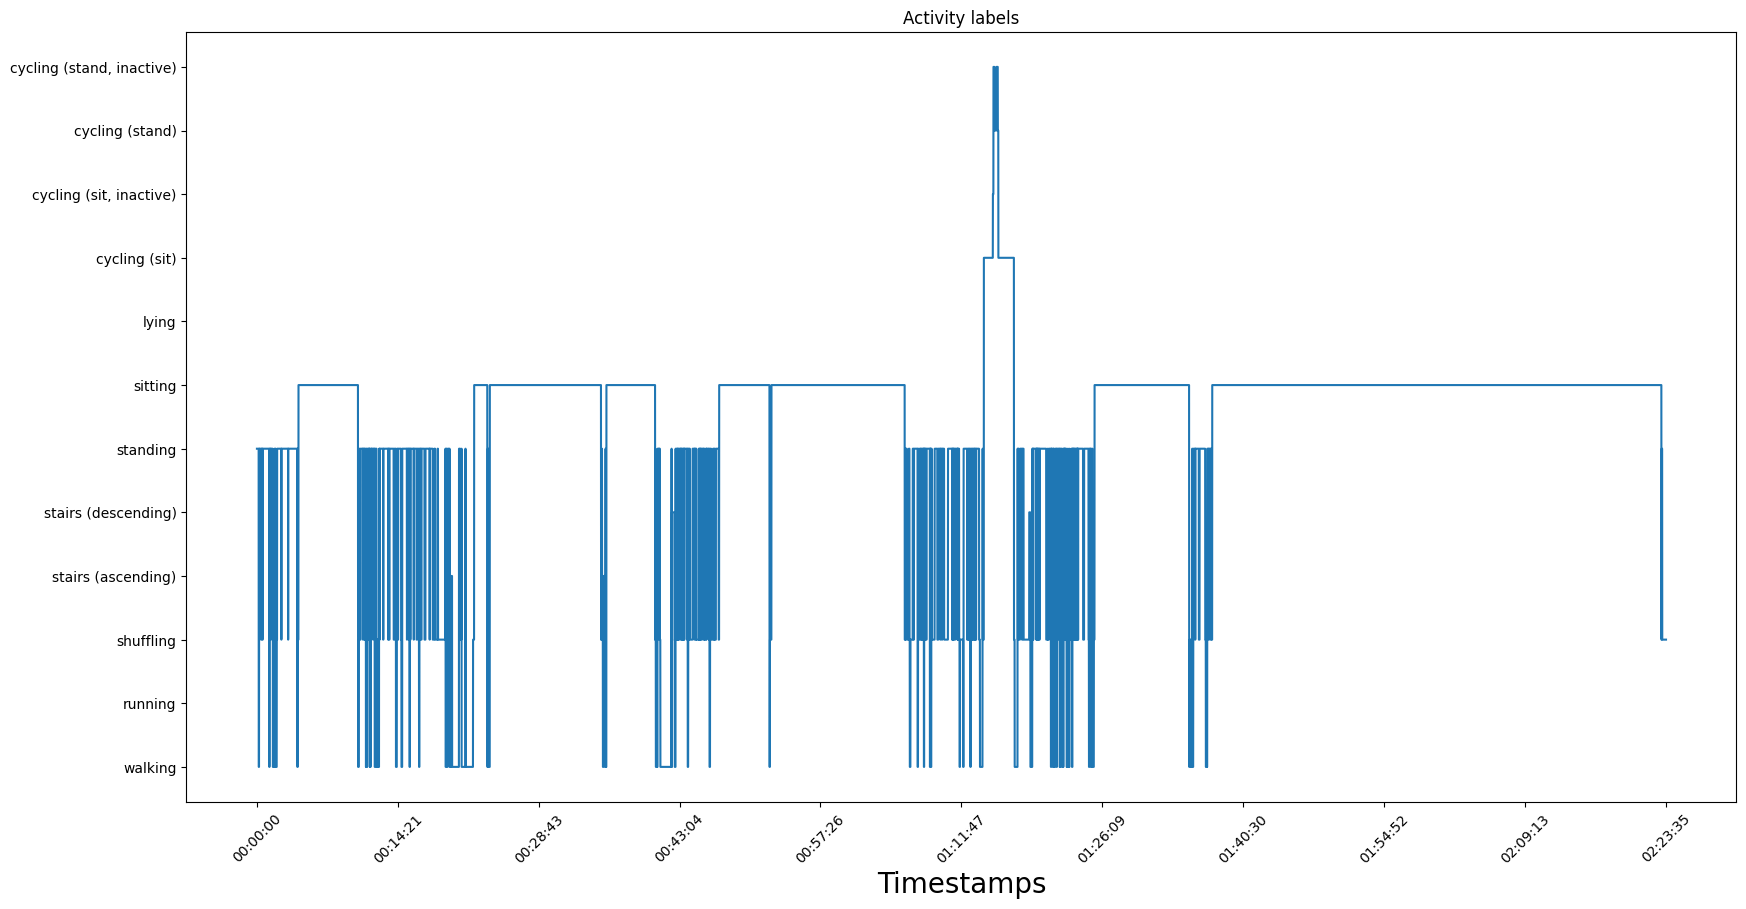

In [3]:
labels_dict = {
    1: "walking",
    2: "running",
    3: "shuffling",
    4: "stairs (ascending)",
    5: "stairs (descending)",
    6: "standing",
    7: "sitting",
    8: "lying",
    9: "cycling (sit)",
    11: "cycling (stand)",
    10: "cycling (sit, inactive)",
    12: "cycling (stand, inactive)",
}

# Assuming you have the timestamps and labels arrays
timestamps = labels.index
# This should be a pandas DatetimeIndex or a similar time index
labels_values = labels.values

# Convert timestamps to show only up to seconds
timestamps_seconds = timestamps.strftime("%H:%M:%S")

# Define the number of timestamps you want to appear
num_ticks = 10  # For example, show 10 timestamps

# Calculate the step size based on the number of ticks
step = max(1, len(timestamps) // num_ticks)

# Plot labels with activity names
plt.figure(figsize=(20, 10))
plt.plot(labels_values)
plt.yticks(list(labels_dict.keys()), list(labels_dict.values()))
plt.title("Activity labels")

# Add xticks based on the calculated step size, and format timestamps to seconds
plt.xticks(
    np.arange(0, len(timestamps_seconds), step=step),
    timestamps_seconds[::step],
    rotation=45,
)

plt.xlabel("Timestamps")
plt.show()


In [4]:
results_path = "../results/activityrecognition/" + str(sr)
# create folders in results path
if not os.path.exists(results_path):
    os.makedirs(results_path + "/mp")
    os.makedirs(results_path + "/mp_indices")

In [5]:
# features = data.columns
# stats_table = pd.DataFrame()
# resids = {}

# # get the data for those features
# for data_feature in features:
#     print(data_feature)
#     time_serie = data[data_feature]
#     # 5hz, 1 second is 4 samples, 1 minute is 300 samples, 1 hour is 18000 samples
#     res = MSTL(
#         time_serie, periods=[int(sr * 60), int(sr * 60 * 60)]
#     ).fit()  # seasonal period is 1 minute, 1 hour
#     resids[data_feature] = res.resid

#     var_resid = np.var(res.resid)
#     var_observed = np.var(res.observed)
#     trend_strength = max(0, 1 - (var_resid / np.var(res.trend + res.resid)))
#     noise_strength = var_resid / var_observed

#     seasonal_individial_strengths = {}
#     for period in res.seasonal:
#         seasonal_individial_strengths["F_" + str(period)] = max(
#             0, 1 - (var_resid / np.var(res.seasonal[period] + res.resid))
#         )
#     seasonal_strength = max(
#         0, 1 - (var_resid / np.var(res.seasonal.sum(axis=1) + res.resid))
#     )

#     stats_df = {
#         "Feature": data_feature,
#         "F_T": round(trend_strength, 3),
#         "F_S": round(seasonal_strength, 3),
#         "F_R": round(noise_strength, 3),
#     }

#     # add individual seasonal strengths to stats_df, rounded with 3 decimals
#     for period in seasonal_individial_strengths:
#         stats_df[period] = round(seasonal_individial_strengths[period], 3)

#     stats_table = pd.concat(
#         [stats_table, pd.DataFrame(stats_df, index=[0])], ignore_index=True
#     )

# pd.DataFrame(resids).to_csv(results_path + "/resids.csv", index=True)
# stats_table = stats_table.sort_values(by=["F_R"], ascending=False)
# stats_table.to_csv(results_path + "/decomposition_summary.csv", index=False)
# stats_table.head().to_latex()

In [6]:
def multivar_subsequence_complexity(x):
    # complexity for multivariate time series can be calculated as the sum of the complexity of each dimension
    return np.sum(np.sqrt(np.sum(np.square(np.diff(x)), axis=1)))


def table_summary_motifs(
    motif_indices,
    motif_distances,
    motif_subspaces,
    data,
    k_distances,
    m,
    normalize,
    max_allowed_dist,
):
    mp_stats_table = pd.DataFrame(
        columns=[
            "ID",
            "k_distances",
            "Features",
            "m",
            "#Matches",
            "Indices",
            "max(dists)",
            "min(dists)",
            "med(dists)",
        ]
    )

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[
            :, np.newaxis
        ]

    dtypes = [float] * len(data)
    model_empirical = NullModel(data, dtypes, model="empirical")

    for motif_indice, match_indices in enumerate(motif_indices):
        dimensions = motif_subspaces[motif_indice]

        # remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        # if is empty, skip
        if len(match_indices) == 0:
            continue

        excl_zone = np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM)

        # remove trivial matches
        non_trivial_matches = []
        for indice in match_indices:
            trivial = False
            for indice_new in non_trivial_matches:
                if abs(indice - indice_new) <= excl_zone:
                    trivial = True
                    break
            if not trivial:
                non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        max_possible_matches = int(np.floor((n_time - m) / excl_zone + 1))

        # get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][
            :, match_indices[0] : match_indices[0] + m
        ]

        # minmax normalize subsequence
        epsilon = 1e-10  # to avoid division by zero
        min_values = multivar_subsequence.min(axis=1, keepdims=True)
        max_values = multivar_subsequence.max(axis=1, keepdims=True)
        normalized_multivar_subsequence = (multivar_subsequence - min_values) / (
            max_values - min_values + epsilon
        )
        ce_norm_subsequence = multivar_subsequence_complexity(
            normalized_multivar_subsequence
        )
        norm_ce_norm_subsequence = ce_norm_subsequence / (
            np.sqrt(len(multivar_subsequence[0]) - 1) * len(dimensions)
        )

        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])

        if k_distances is None:  # consider all matches
            med_dist = np.median(match_distances[1:])
        else:  # consider only the k closest matches
            med_dist = np.median(match_distances[1 : k_distances + 1])

        # np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)])
        if max_allowed_dist is None:
            current_data = data[dimensions]
            n_vars, n_time = current_data.shape

            # D The distance profile of `Q` with `T`. It is a 1D numpy array of size
            # `len(T)-len(Q)+1`, where `D[i]` is the distance between query `Q` and
            # `T[i : i + len(Q)]`
            D = np.empty((n_vars, n_time - m + 1))
            for i in range(n_vars):
                D[i, :] = stumpy.mass(
                    multivar_subsequence[i], current_data[i], normalize=normalize
                )
            D = np.mean(D, axis=0)
            D_copy = D.copy().astype(np.float64)
            D_copy[np.isinf(D_copy)] = np.nan
            motif_max_allowed_dist = np.nanmax(
                [np.nanmean(D_copy) - 2.0 * np.nanstd(D_copy), np.nanmin(D_copy)]
            )
        else:
            motif_max_allowed_dist = max_allowed_dist

        unified_weights = "0.33,0.33,0.33"
        w1, w2, w3 = map(float, unified_weights.split(","))
        unified = (
            w1 * (1 - (med_dist / motif_max_allowed_dist))
            + w2 * (len(match_indices) / max_possible_matches)
            + w3 * norm_ce_norm_subsequence
        )

        # remove timepoints from time series in match all indices + m
        time_series_nomatches = data.copy()
        # list of indexes to remove
        indexes_to_remove = [
            i for index in match_indices for i in range(index, index + m)
        ]
        # put zero in the indexes to remove
        time_series_nomatches[:, indexes_to_remove] = 0

        # calculate variance explained by the motif
        vars_explained = []
        for i in range(len(dimensions)):
            vars_explained.append(
                100
                * (
                    1
                    - (
                        np.mean(np.abs(time_series_nomatches[i]))
                        / np.mean(np.abs(data[i]))
                    )
                )
            )

        variance_explained = np.mean(vars_explained)

        # data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        # max_delta = motif_max_allowed_dist # (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(motif_max_allowed_dist**2 / m)
        delta_thresholds = [max_delta] * len(data)

        #########SIG#########
        motif = Motif(
            multivar_subsequence, dimensions, delta_thresholds, len(match_indices)
        )
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(
            max_possible_matches, n_vars, idd_correction=False
        )

        stats_df = {
            "ID": str(motif_index),
            "k": len(dimensions),
            "Features": ",".join(used_features),
            "m": m,
            "#Matches": len(match_indices) - 1,
            "Indices": match_indices,
            "max(dists)": np.around(max_dist, 3),
            "min(dists)": np.around(min_dist, 3),
            "med(dists)": np.around(med_dist, 3),
            "CE": np.around(norm_ce_norm_subsequence, 3),
            "Score Unified": np.around(unified, 3),
            "Explained Var(%)": np.around(variance_explained, 2),
            "P": p,
            "p-value": pvalue,
        }

        mp_stats_table = (
            pd.DataFrame.from_records([stats_df])
            if mp_stats_table.empty
            else pd.concat(
                [mp_stats_table, pd.DataFrame.from_records([stats_df])],
                ignore_index=True,
            )
        )

        motif_index += 1
    return mp_stats_table

In [7]:
# motif discovery
import stumpy
from stumpy import config

config.STUMPY_EXCL_ZONE_DENOM = 2  # r = np.ceil(m/2)
top_k_mp = 1
include = None
normalize = False
subsequence_lengths = [sr * 15, sr * 30, sr * 60 * 1]  # 15s, 30s, 1m

resids = pd.read_csv(results_path + "/resids.csv", index_col=0).T

# for m in subsequence_lengths:
#     mp, mp_indices = stumpy.mstump(resids.values, m, normalize=normalize)
#     np.save(
#         results_path
#         + "/mp/normalize={}_topkmp={}_m={}_multivariate.npy".format(
#             normalize, top_k_mp, m
#         ),
#         mp,
#         allow_pickle=True,
#     )
#     np.save(
#         results_path
#         + "/mp_indices/normalize={}_topkmp={}_m={}_multivariate.npy".format(
#             normalize, top_k_mp, m
#         ),
#         mp_indices,
#         allow_pickle=True,
#     )

In [8]:
k_distances = None
min_neighbors = 2
cutoff = np.inf
max_matches = 99999
max_distance = None
max_motifs = 99999
k = None

mp_stats_table = pd.DataFrame()
for m in subsequence_lengths:
    print(m)
    X = resids.values
    mp = np.load(
        results_path
        + "/mp/normalize={}_topkmp={}_m={}_multivariate.npy".format(
            normalize, top_k_mp, m
        ),
        allow_pickle=True,
    )
    mp_indices = np.load(
        results_path
        + "/mp_indices/normalize={}_topkmp={}_m={}_multivariate.npy".format(
            normalize, top_k_mp, m
        ),
        allow_pickle=True,
    )

    motif_distances, motif_indices, motif_subspaces, motif_mdls = stumpy.mmotifs(
        X,
        mp,
        mp_indices,
        min_neighbors=min_neighbors,
        max_distance=max_distance,
        cutoffs=np.inf,
        max_matches=max_matches,
        max_motifs=max_motifs,
        k=k,
        include=include,
        normalize=normalize,
    )

    if len(motif_indices[0]) == 0:
        continue
    table = table_summary_motifs(
        motif_indices,
        motif_distances,
        motif_subspaces,
        X,
        k_distances,
        m,
        normalize,
        max_distance,
    )
    logging.info(
        "m:{}, #Motifs:{}, Sig:{}".format(
            m, len(motif_indices), np.sum(table["p-value"] < 0.001)
        )
    )
    # hochberg procedure
    p_values = table["p-value"].to_numpy()
    critical_value = NullModel.hochberg_critical_value(p_values, 0.05)
    sig = (
        table["p-value"] < critical_value
        if critical_value != 0
        else table["p-value"] <= critical_value
    )
    table["Sig_Hochber"] = sig
    logging.info(
        "Sig after Hochberg: {}, critical value: {}".format(np.sum(sig), critical_value)
    )
    mp_stats_table = (
        table
        if mp_stats_table.empty
        else pd.concat([mp_stats_table, table], ignore_index=True)
    )

    mp_stats_table.to_csv(
        results_path
        + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv".format(
            normalize, min_neighbors, max_distance, cutoff, max_matches, max_motifs
        ),
        index=False,
    )

60


INFO:root:p_value = 0.000E+00 (p_pattern = 8.749E-105)
INFO:root:p_value = 0.000E+00 (p_pattern = 4.202E-83)
INFO:root:p_value = 0.000E+00 (p_pattern = 2.871E-66)
INFO:root:p_value = 0.000E+00 (p_pattern = 9.406E-80)
INFO:root:p_value = 0.000E+00 (p_pattern = 2.942E-88)
INFO:root:p_value = 0.000E+00 (p_pattern = 3.620E-98)
INFO:root:p_value = 0.000E+00 (p_pattern = 1.861E-85)
INFO:root:p_value = 0.000E+00 (p_pattern = 5.486E-100)
INFO:root:p_value = 0.000E+00 (p_pattern = 3.043E-87)
INFO:root:p_value = 3.300E-293 (p_pattern = 1.153E-35)
INFO:root:p_value = 0.000E+00 (p_pattern = 8.547E-37)
INFO:root:p_value = 0.000E+00 (p_pattern = 1.072E-64)
INFO:root:p_value = 0.000E+00 (p_pattern = 4.503E-46)
INFO:root:p_value = 2.746E-320 (p_pattern = 2.785E-67)
INFO:root:p_value = 0.000E+00 (p_pattern = 3.398E-58)
INFO:root:p_value = 0.000E+00 (p_pattern = 1.384E-37)
INFO:root:p_value = 0.000E+00 (p_pattern = 1.253E-89)
INFO:root:p_value = 0.000E+00 (p_pattern = 4.493E-58)
INFO:root:m:60, #Motifs:

120


INFO:root:p_value = 0.000E+00 (p_pattern = 1.528E-168)
INFO:root:p_value = 0.000E+00 (p_pattern = 2.678E-133)
INFO:root:p_value = 0.000E+00 (p_pattern = 3.558E-168)
INFO:root:p_value = 0.000E+00 (p_pattern = 1.178E-136)
INFO:root:p_value = 0.000E+00 (p_pattern = 6.365E-168)
INFO:root:p_value = 0.000E+00 (p_pattern = 5.720E-73)
INFO:root:p_value = 0.000E+00 (p_pattern = 2.900E-144)
INFO:root:p_value = 0.000E+00 (p_pattern = 1.066E-95)
INFO:root:p_value = 0.000E+00 (p_pattern = 7.785E-118)
INFO:root:p_value = 0.000E+00 (p_pattern = 1.295E-107)
INFO:root:p_value = 0.000E+00 (p_pattern = 3.879E-152)
INFO:root:p_value = 0.000E+00 (p_pattern = 9.388E-184)
INFO:root:p_value = 0.000E+00 (p_pattern = 1.277E-215)
INFO:root:p_value = 0.000E+00 (p_pattern = 1.759E-103)
INFO:root:m:120, #Motifs:14, Sig:14
INFO:root:Sig after Hochberg: 14, critical value: 0.0


240


INFO:root:p_value = 0.000E+00 (p_pattern = 8.657E-277)
INFO:root:p_value = 0.000E+00 (p_pattern = 8.667E-280)
INFO:root:p_value = 0.000E+00 (p_pattern = 2.083E-182)
INFO:root:p_value = 0.000E+00 (p_pattern = 9.829E-163)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:76: RuntimeWarning: overflow encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
INFO:root:p_value = 0.000E+00 (p_pattern = 1.589E-314)
INFO:root:p_value = 0.000E+00 (p_pattern = 1.647E-316)
INFO:root:m:240, #Motifs:6, Sig:6
INFO:root:Sig after Hochberg: 6, critical value: 0.0


In [9]:
# read motifs table
mp_stats_table = pd.read_csv(
    results_path
    + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv".format(
        normalize, min_neighbors, max_distance, cutoff, max_matches, max_motifs
    )
)

# for motif in mp_stats_table
indexes_to_remove = set()
for index, motif in mp_stats_table.iterrows():
    indexes_to_remove.update(
        [
            i
            for index in eval(motif["Indices"])
            for i in range(int(index), int(index) + int(motif["m"]))
        ]
    )

datetime_indexes_to_remove = resids.T.index[sorted(indexes_to_remove)]

residual_nomatches = resids.T.copy()
for feature in residual_nomatches.columns:
    residual_nomatches.loc[datetime_indexes_to_remove, feature] = 0
    variance_explained = 100 * (
        1
        - (
            np.mean(np.abs(residual_nomatches[feature]))
            / np.mean(np.abs(resids.T[feature]))
        )
    )
    print(f"{feature}: {variance_explained}")

back_x: 39.05130458872242
back_y: 38.31098379421645
back_z: 43.437906696137375
thigh_x: 47.30500308268011
thigh_y: 43.894774305483395
thigh_z: 45.47175390306483


In [10]:
# create a new table for each motif length with statistics of the motifs (number of motifs found,
# number of significant motifs, average number of matches +- std, average of features +- std,
# average probability +- std, average pvalue +- std)

mp_stats_table = pd.read_csv(
    results_path
    + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv".format(
        normalize, min_neighbors, max_distance, cutoff, max_matches, max_motifs
    )
)
motif_lengths = mp_stats_table["m"].unique()
motif_stats_table = pd.DataFrame(
    columns=[
        "m",
        "#motifs",
        "avg_n_matches",
        "avg_n_features",
        "avg_probability",
        "avg_pvalue",
        "#sig_motifs(<0.01)",
        "significant",
        "#sig_hochberg",
    ]
)
for m in subsequence_lengths:
    table = mp_stats_table[mp_stats_table["m"] == m]
    if table.empty:
        continue
    n_motifs = table.shape[0]
    n_sig_motifs_0001 = table[table["p-value"] < 0.001].shape[0]
    n_sig_motifs_hochberg = table[table["Sig_Hochber"]].shape[0]
    avg_n_matches = (
        round(table["#Matches"].mean(), 2),
        round(table["#Matches"].std(), 3),
    )
    avg_n_features = round(table["k"].mean(), 2), round(table["k"].std(), 3)
    avg_probability = table["P"].mean(), table["P"].std()
    avg_pvalue = table["p-value"].mean(), table["p-value"].std()

    stats_df = {
        "m": m,
        "#motifs": n_motifs,
        "#sig_motifs(<0.001)": n_sig_motifs_0001,
        "significant": (n_sig_motifs_0001 * 100) / n_motifs,
        "avg_n_matches": avg_n_matches,
        "avg_n_features": avg_n_features,
    }

    motif_stats_table = (
        pd.DataFrame.from_records([stats_df])
        if motif_stats_table.empty
        else pd.concat(
            [motif_stats_table, pd.DataFrame.from_records([stats_df])],
            ignore_index=True,
        )
    )
print(motif_stats_table.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrrll}
\toprule
m & #motifs & #sig_motifs(<0.001) & significant & avg_n_matches & avg_n_features \\
\midrule
60 & 18 & 18 & 100.000 & (13.94, 6.717) & (5.67, 0.686) \\
120 & 14 & 14 & 100.000 & (6.57, 3.081) & (5.57, 0.756) \\
240 & 6 & 6 & 100.000 & (3.67, 1.366) & (5.5, 0.837) \\
\bottomrule
\end{tabular}



In [11]:
mp_stats_table = pd.read_csv(
    results_path
    + "/table_motifs_normalize={}_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv".format(
        normalize, min_neighbors, max_distance, cutoff, max_matches, max_motifs
    )
)
# excluded p-value > 0.001
mp_stats_table = mp_stats_table[mp_stats_table["p-value"] < 0.001]
subsequence_lengths = mp_stats_table["m"].unique()
for m in subsequence_lengths:
    print("########## m:{} #########".format(m))
    top_motifs = mp_stats_table[mp_stats_table["m"] == m]
    top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(5)
    top_motifs = top_motifs[
        [
            "ID",
            "#Matches",
            "CE",
            "Score Unified",
            "max(dists)",
            "min(dists)",
            "med(dists)",
            "p-value",
            "Explained Var(%)",
        ]
    ]
    top_motifs["p-value"] = top_motifs["p-value"].apply(lambda x: f"{x:.2e}")
    print(top_motifs.to_latex(index=False, float_format="%.3f"))
    print("\n")

########## m:60 #########
\begin{tabular}{rrrrrrrlr}
\toprule
ID & #Matches & CE & Score Unified & max(dists) & min(dists) & med(dists) & p-value & Explained Var(%) \\
\midrule
9 & 8 & 0.197 & 0.292 & 0.938 & 0.262 & 0.364 & 3.30e-293 & 3.440 \\
10 & 18 & 0.174 & 0.219 & 0.870 & 0.340 & 0.550 & 0.00e+00 & 7.320 \\
6 & 13 & 0.190 & 0.172 & 0.249 & 0.022 & 0.184 & 0.00e+00 & 3.200 \\
0 & 3 & 0.206 & 0.158 & 0.183 & 0.022 & 0.179 & 0.00e+00 & 0.960 \\
15 & 29 & 0.209 & 0.140 & 1.009 & 0.583 & 0.826 & 0.00e+00 & 10.490 \\
\bottomrule
\end{tabular}



########## m:120 #########
\begin{tabular}{rrrrrrrlr}
\toprule
ID & #Matches & CE & Score Unified & max(dists) & min(dists) & med(dists) & p-value & Explained Var(%) \\
\midrule
5 & 4 & 0.159 & 0.221 & 1.594 & 0.494 & 0.804 & 0.00e+00 & 3.910 \\
7 & 9 & 0.182 & 0.193 & 1.518 & 0.631 & 1.017 & 0.00e+00 & 7.130 \\
3 & 5 & 0.158 & 0.181 & 0.274 & 0.031 & 0.272 & 0.00e+00 & 3.050 \\
1 & 11 & 0.150 & 0.141 & 0.466 & 0.031 & 0.353 & 0.00e+00 & 5.710

In [30]:
def plot_motif(ts_list, features, m, motif_indexes, motif_name, results_path):
    fig, axes = plt.subplots(
        ncols=2, nrows=len(ts_list), figsize=(10, 1.5 * len(ts_list)), squeeze=False
    )
    
    # Total duration in seconds (2 hours, 23 minutes, 36.5 seconds)
    total_time_seconds = 2 * 3600 + 23 * 60 + 36.5
    # Number of data points
    total_data_points = 34467
    # Time per index (seconds)
    time_per_index = total_time_seconds / total_data_points

    # Determine indices for 15-minute intervals (900 seconds)
    seconds_per_tick = 15 * 60  # 15 minutes in seconds
    tick_indices = np.arange(0, total_data_points, int(seconds_per_tick / time_per_index))

    # Create corresponding time labels for the xticks, rounding to nearest second
    def format_time(seconds):
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        seconds = int(seconds % 60)
        return f'{hours:02d}:{minutes:02d}:00'  # Force seconds to always be 00
    
    xtick_labels = [format_time(i * time_per_index) for i in tick_indices]

    for i in range(len(ts_list)):
        ts = ts_list[i]
        feature = features[i]
        axes[i, 1].plot(ts, color="black", linewidth=0.5, alpha=0.5)

        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i, 0].set_prop_cycle("color", colors)
        axes[i, 1].set_prop_cycle("color", colors)

        plotted_values = set()

        for index in motif_indexes:
            subsequence_match = ts.iloc[index: index + m]
            axes[i, 0].plot(subsequence_match.values)
            axes[i, 1].plot(subsequence_match, linewidth=4)

            plotted_values.update(subsequence_match.values)

        xticks = [0] + list(range(max(1, m // 5), m - 1, max(1, m // 5))) + [m - 1]
        xticklabels = ['i'] + [f'i+{t}' for t in xticks[1:-1]] + [f'i+{m-1}']
        
        axes[i, 0].set_xticks(xticks)
        axes[i, 0].set_xticklabels(xticklabels)
        plt.setp(axes[i, 0].xaxis.get_majorticklabels(), rotation=90)

        if i != len(ts_list) - 1:
            axes[i, 0].axes.get_xaxis().set_visible(False)
            axes[i, 1].axes.get_xaxis().set_visible(False)

        # Set xticks and labels for the right plot (axes[i, 1])
        axes[i, 1].set_xticks(tick_indices)
        axes[i, 1].set_xticklabels(xtick_labels, rotation=45)

        axes[i, 0].set_ylabel(features[i], rotation=90, size="large")

    axes[0, 0].set_title("Raw Subsequences")
    axes[0, 1].set_title("Motif in Residual TS")
    plt.tight_layout()
    plt.savefig(results_path + 
        "/m=" + str(m) + "_motif_" + str(motif_name) + ".pdf",
        bbox_inches="tight",
    )

    return None


In [19]:
# Load motif statistics table
file_path = os.path.join(
    results_path,
    f"table_motifs_normalize={normalize}_min_neighbors={min_neighbors}_max_distance={max_distance}_cutoff={cutoff}_max_matches={max_matches}_max_motifs={max_motifs}.csv",
)
mp_stats_table = pd.read_csv(file_path)

# Extract unique subsequence lengths
subsequence_lengths = mp_stats_table["m"].unique()

# Time series data
ts = resids
timestamps = pd.to_datetime(ts.T.index)

INFO:root:Motif length: 60


{'ID': 6, 'k': 6, 'Features': '1,0,4,2,3,5', 'm': 60, '#Matches': 13, 'Indices': '[744, 29544, 796, 896, 29696, 927, 29596, 29727, 863, 29663, 830, 29630, 29513, 713]', 'max(dists)': 0.249, 'min(dists)': 0.022, 'med(dists)': 0.184, 'CE': 0.19, 'Score Unified': 0.172, 'Explained Var(%)': 3.2, 'P': 1.8614177025449468e-85, 'p-value': 0.0, 'Sig_Hochber': True}
[6 3]
[6 3]
[6]
[6]
[6]
[6]
[6]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


{'ID': 0, 'k': 6, 'Features': '1,0,3,4,2,5', 'm': 60, '#Matches': 3, 'Indices': '[0, 28800, 31, 28831]', 'max(dists)': 0.183, 'min(dists)': 0.022, 'med(dists)': 0.179, 'CE': 0.206, 'Score Unified': 0.158, 'Explained Var(%)': 0.96, 'P': 8.748947593326236e-105, 'p-value': 0.0, 'Sig_Hochber': True}
[6 1 3]
[6 1 3]
[7]
[7]
{'ID': 15, 'k': 4, 'Features': '0,1,2,3', 'm': 60, '#Matches': 29, 'Indices': '[16453, 16515, 16707, 16484, 16248, 16160, 16676, 16744, 15857, 16621, 16212, 15961, 16401, 15896, 19750, 16590, 16368, 16311, 15994, 16280, 16546, 19833, 16777, 15930, 16025, 19710, 19788, 16107, 19868, 16056]', 'max(dists)': 1.009, 'min(dists)': 0.583, 'med(dists)': 0.826, 'CE': 0.209, 'Score Unified': 0.14, 'Explained Var(%)': 10.49, 'P': 1.3841862221634565e-37, 'p-value': 0.0, 'Sig_Hochber': True}
[6 3]
[3 6]
[3 6 1]
[3 1]
[3 6]
[3 6]
[3 6]
[6 1]
[1 3 6]
[6 3]
[6 3]
[6 3 1]
[6 1 3]
[3 6]
[6 1]
[6 1 3]
[1 6 3]
[3]
[3 6]
[6 3]
[6 3]
[6 3]
[6 3]
[6 3]
[6 3]
[1 3 6]
[6 3 1]
[6 3 1]
[6 3 1]
[1 

INFO:root:Motif length: 120


{'ID': 3, 'k': 6, 'Features': '1,0,4,2,3,5', 'm': 120, '#Matches': 5, 'Indices': '[730, 29530, 791, 867, 29591, 29669]', 'max(dists)': 0.274, 'min(dists)': 0.031, 'med(dists)': 0.272, 'CE': 0.158, 'Score Unified': 0.181, 'Explained Var(%)': 3.05, 'P': 1.1780849739105979e-136, 'p-value': 0.0, 'Sig_Hochber': True}
[6 3]
[6]
[6]
[7]
[7]
[7]
{'ID': 1, 'k': 6, 'Features': '0,1,4,2,3,5', 'm': 120, '#Matches': 11, 'Indices': '[184, 28984, 107, 28907, 46, 28846, 29061, 261, 29286, 322, 488, 29122]', 'max(dists)': 0.466, 'min(dists)': 0.031, 'med(dists)': 0.353, 'CE': 0.15, 'Score Unified': 0.141, 'Explained Var(%)': 5.71, 'P': 2.67791850513799e-133, 'p-value': 0.0, 'Sig_Hochber': True}
[1 3 6]
[3 6]
[6 1]
[6 1 3]
[3 6 1]
[3 6]
[7]
[7]
[7]
[7]
[7]
[7]
{'ID': 4, 'k': 5, 'Features': '0,2,1,3,5', 'm': 120, '#Matches': 2, 'Indices': '[15475, 15715, 15536]', 'max(dists)': 0.465, 'min(dists)': 0.245, 'med(dists)': 0.355, 'CE': 0.133, 'Score Unified': 0.125, 'Explained Var(%)': 2.31, 'P': 6.3652409105

INFO:root:Motif length: 240


{'ID': 2, 'k': 6, 'Features': '0,5,4,1,3,2', 'm': 240, '#Matches': 4, 'Indices': '[14403, 14531, 14668, 14789, 14910]', 'max(dists)': 2.309, 'min(dists)': 1.069, 'med(dists)': 1.527, 'CE': 0.126, 'Score Unified': 0.16, 'Explained Var(%)': 7.79, 'P': 2.083271803942915e-182, 'p-value': 0.0, 'Sig_Hochber': True}
[7]
[7]
[7]
[7]
[7]
{'ID': 0, 'k': 6, 'Features': '1,0,4,3,2,5', 'm': 240, '#Matches': 3, 'Indices': '[0, 28800, 28928, 133]', 'max(dists)': 0.531, 'min(dists)': 0.044, 'med(dists)': 0.528, 'CE': 0.132, 'Score Unified': 0.125, 'Explained Var(%)': 4.21, 'P': 8.657436155597521e-277, 'p-value': 0.0, 'Sig_Hochber': True}
[6 1 3]
[6 3 1]
[7]
[7]
{'ID': 3, 'k': 4, 'Features': '0,1,2,3', 'm': 240, '#Matches': 4, 'Indices': '[16571, 15852, 16396, 16219, 16088]', 'max(dists)': 1.284, 'min(dists)': 1.188, 'med(dists)': 1.262, 'CE': 0.137, 'Score Unified': 0.094, 'Explained Var(%)': 8.36, 'P': 9.828930804173712e-163, 'p-value': 0.0, 'Sig_Hochber': True}
[3 6 1]
[6 1 3]
[6 3 1]
[6 1 3]
[3 6]


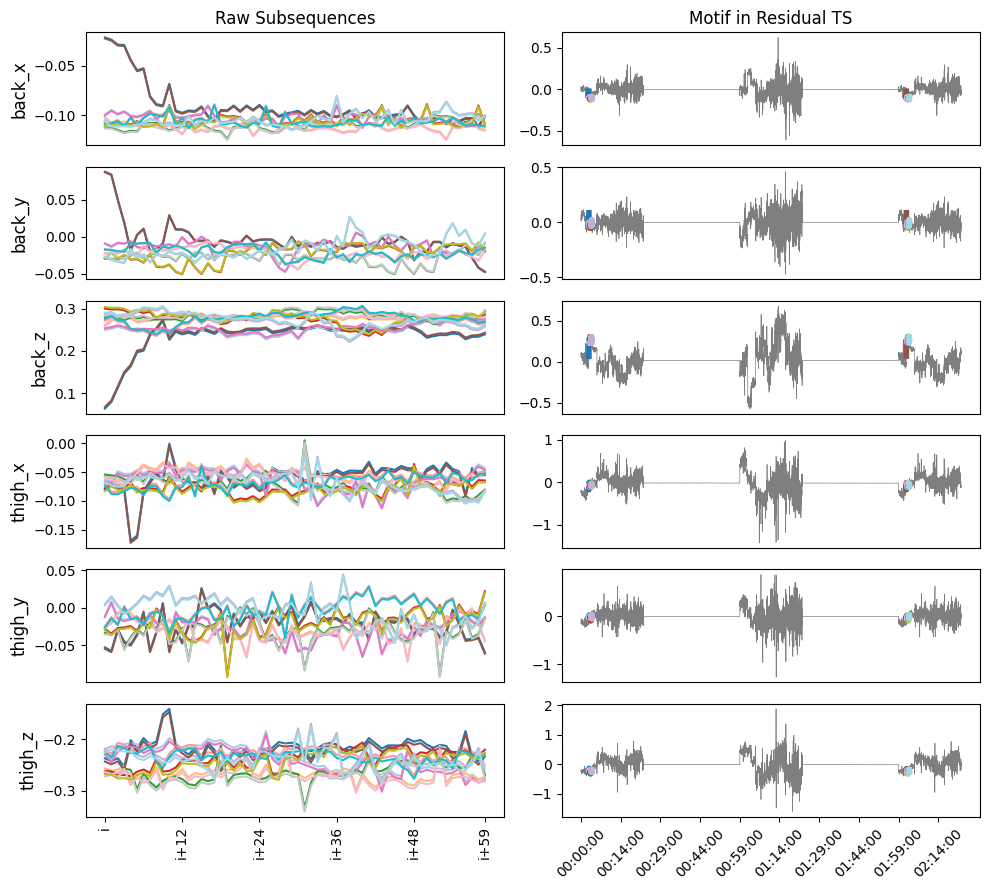

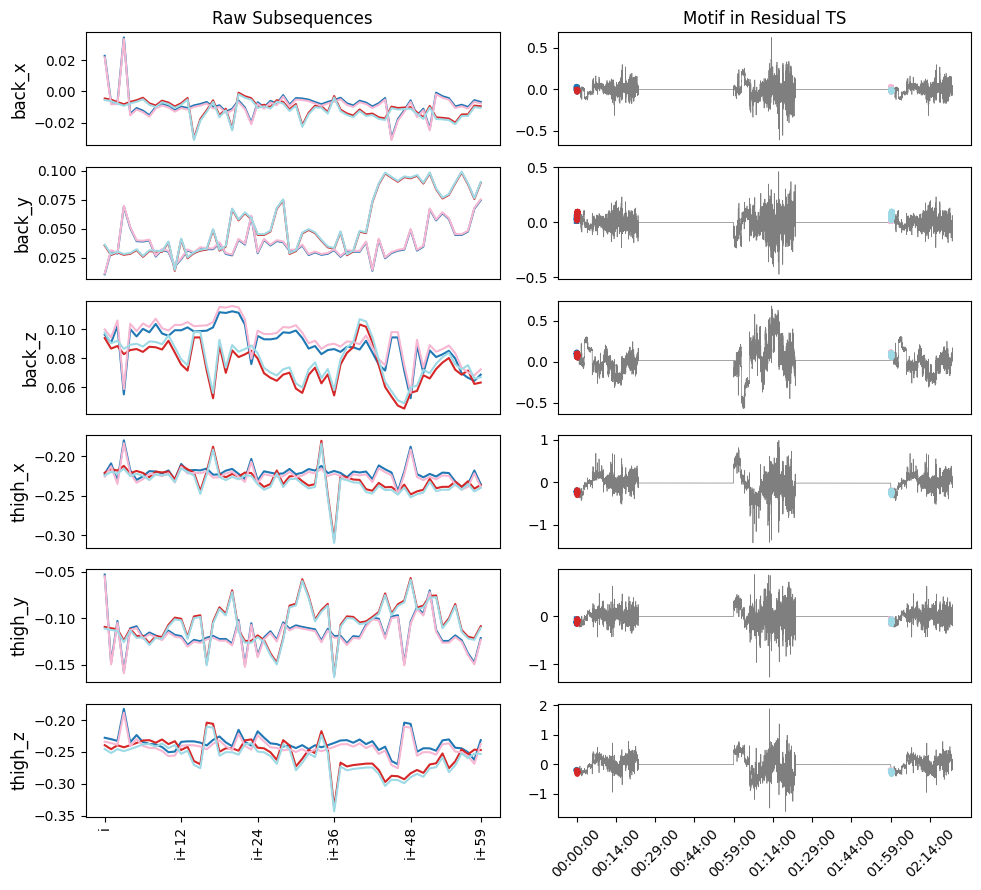

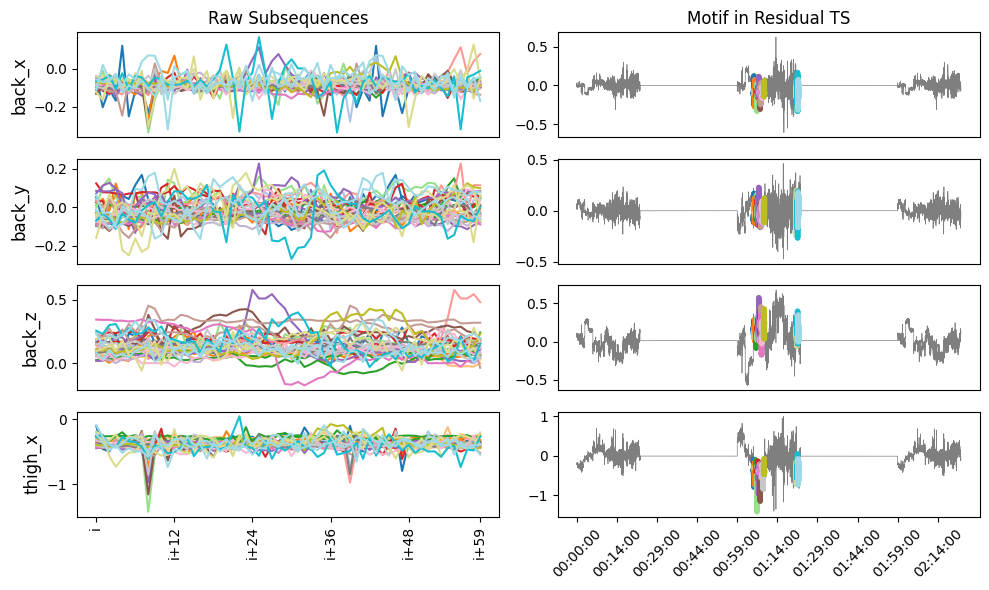

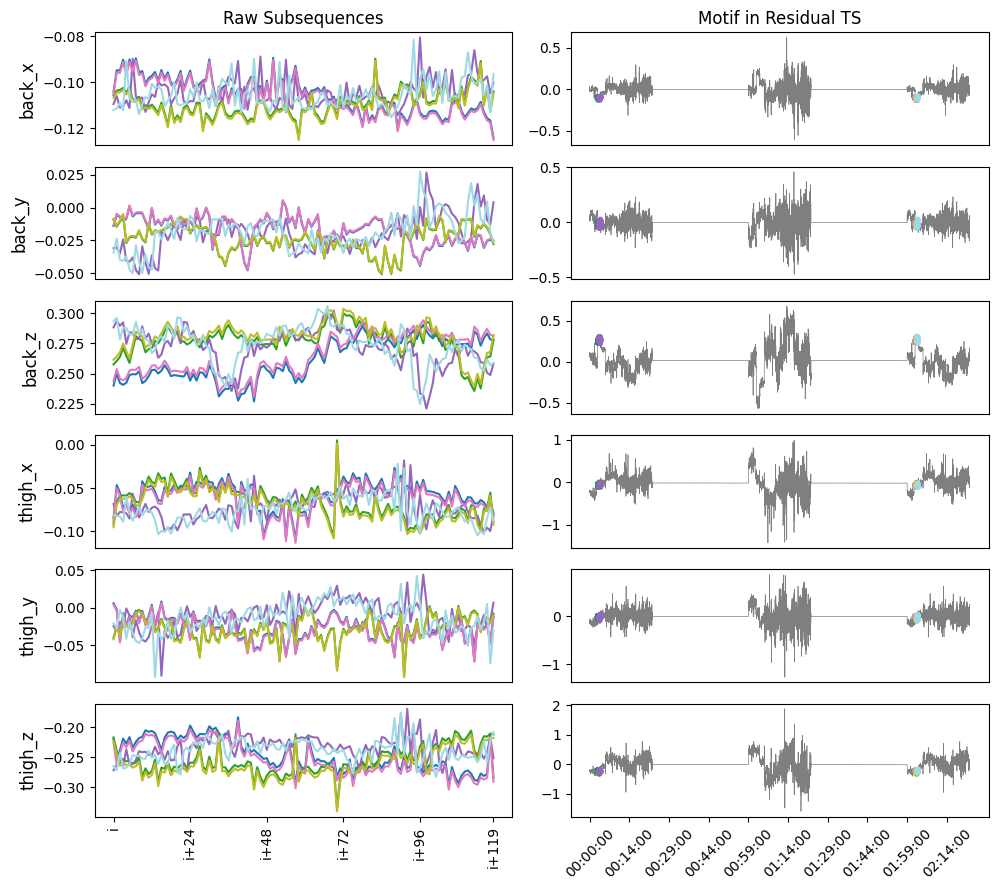

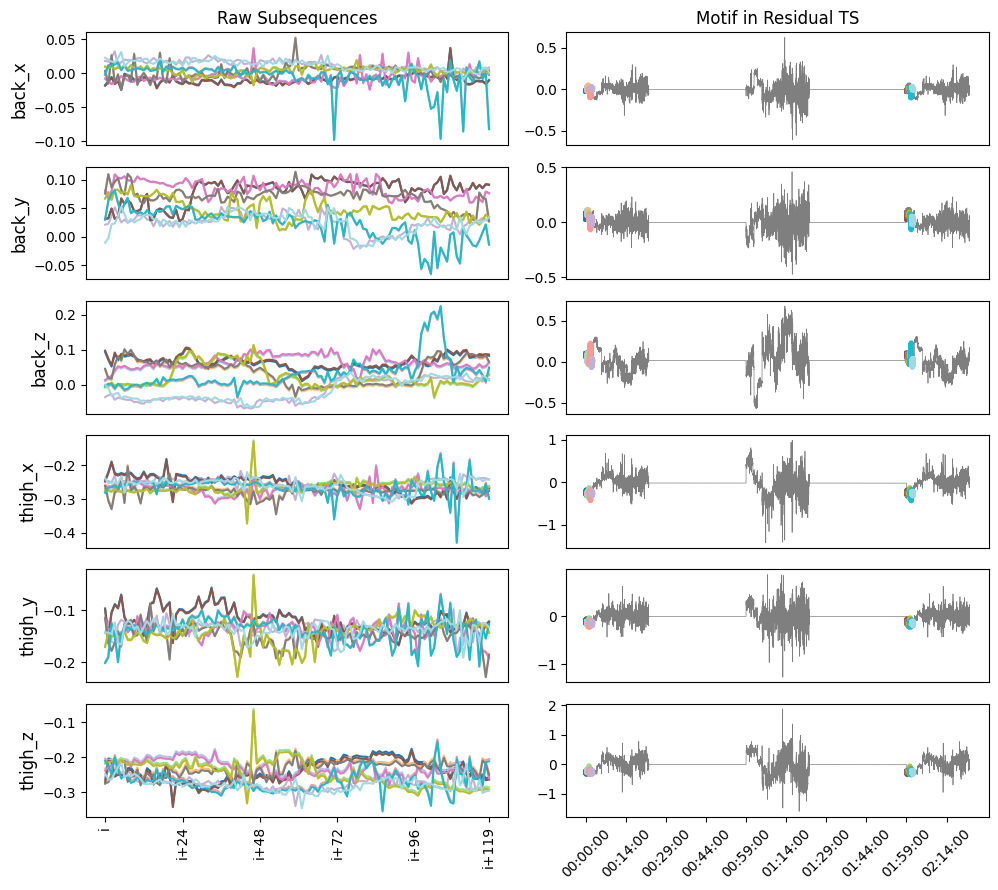

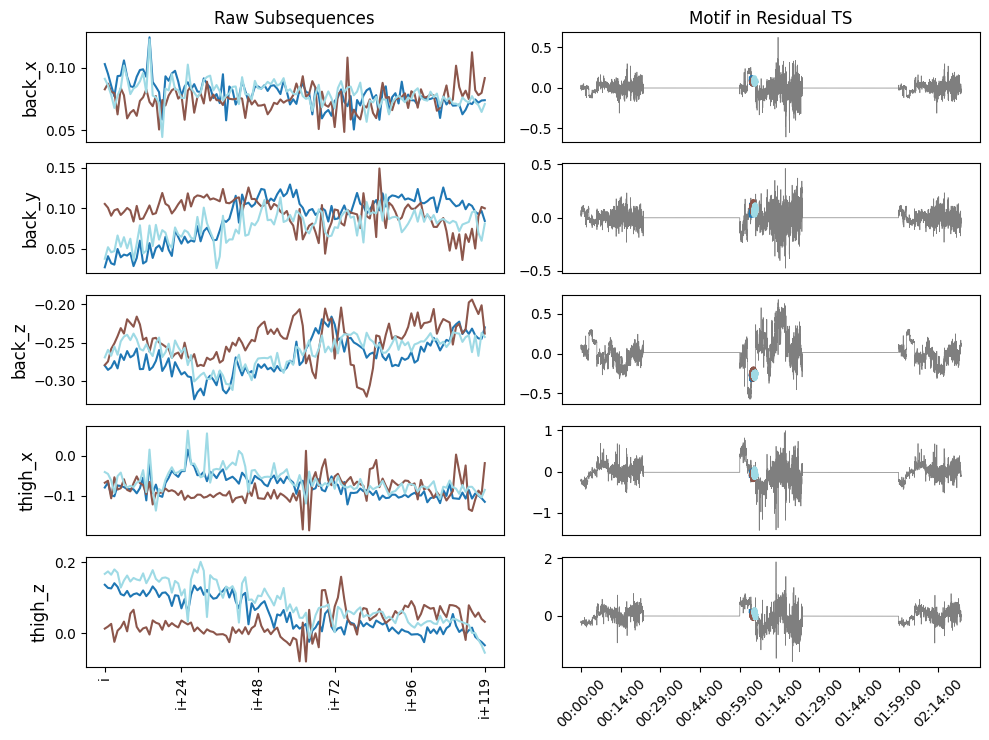

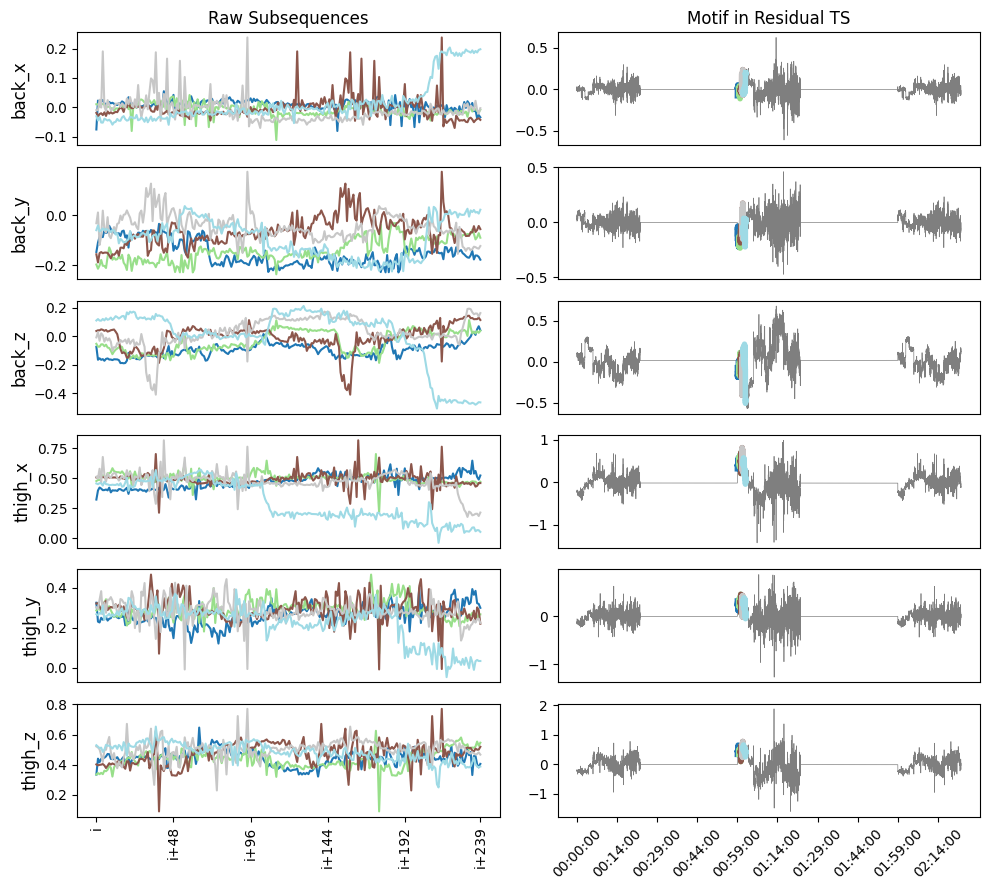

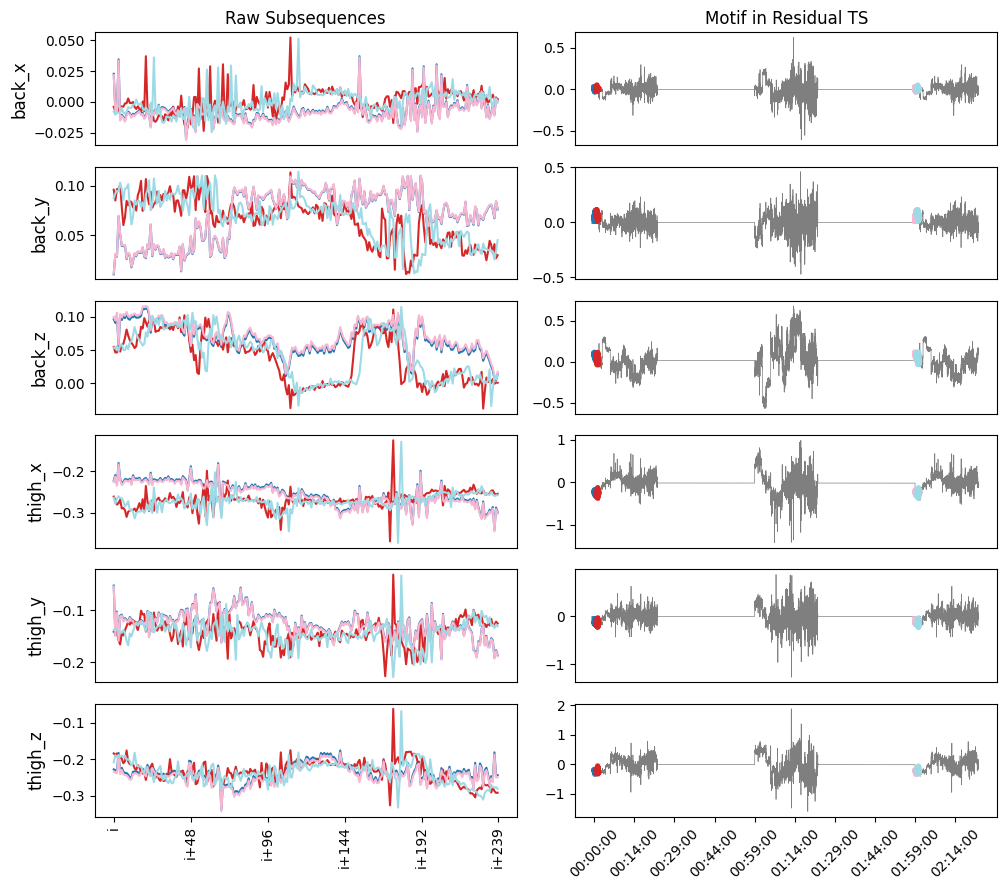

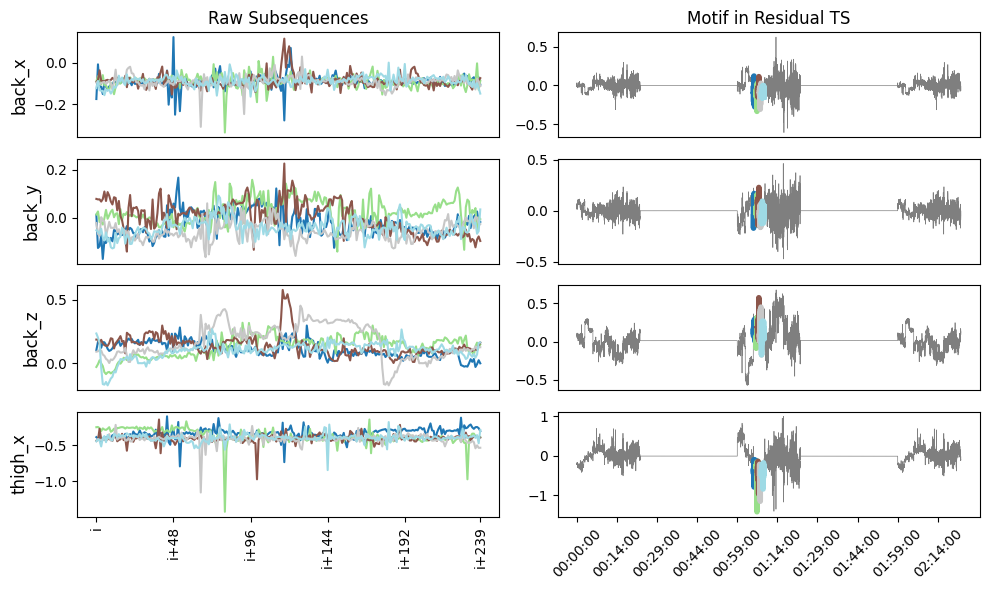

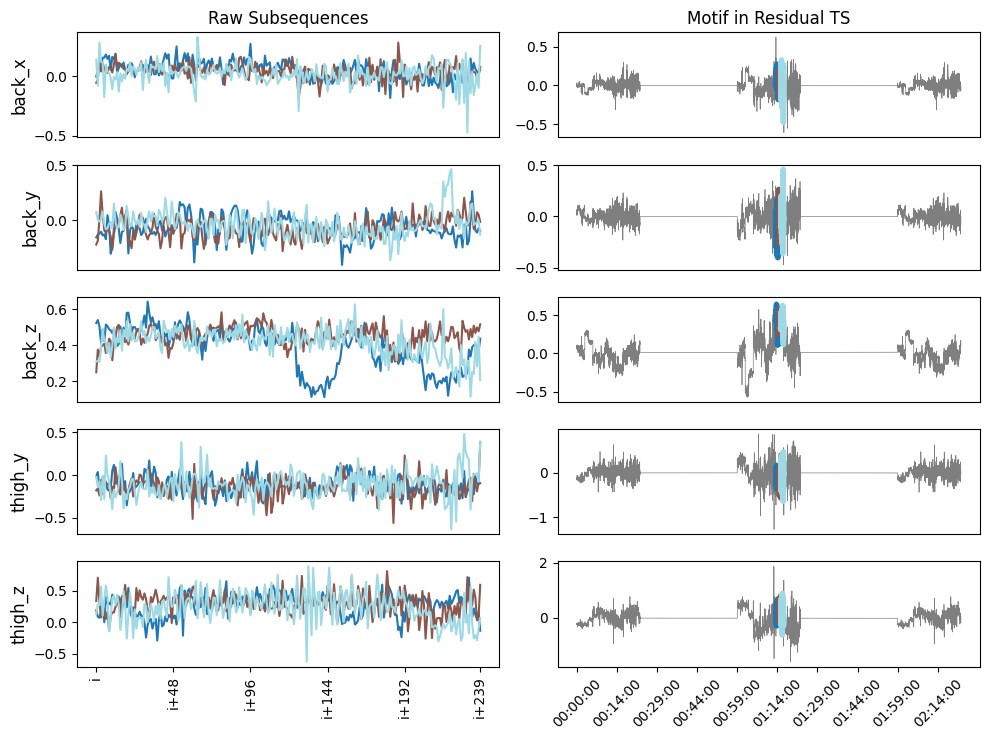

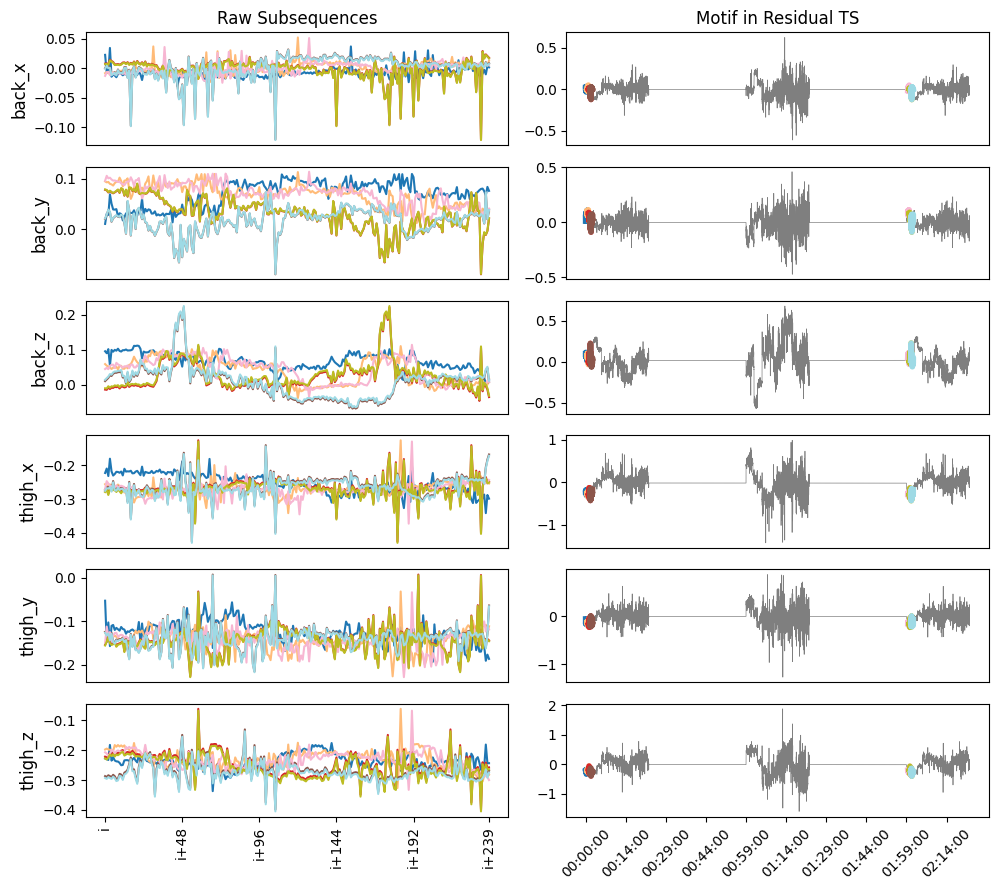

In [37]:
# Loop over each subsequence length
for m in subsequence_lengths:
    logging.info(f"Motif length: {m}")

    # Filter motifs by current subsequence length
    top_motifs = mp_stats_table[mp_stats_table["m"] == m]

    top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(5)

    # Loop over each top motif
    for top_motif in top_motifs.to_dict(orient="records"):
        # Parse dimensions and indices
        dimensions = sorted(map(int, top_motif["Features"].split(",")))
        indices = sorted(map(int, top_motif["Indices"].strip("[]").split(",")))

        # Extract feature names from the data columns
        features = [data.columns[dimension] for dimension in dimensions]

        # Add "Activity" feature and corresponding time series
        ts_list = [resids.T[feature].reset_index(drop=True) for feature in features]
        # ts_list.append(labels)
        # features.append("Activity")

        # Generate motif name
        motif_name = top_motif["ID"]

        # Check if the indices are far enough apart (delta >= 1000)
        if any(
            abs(indices[i] - indices[i + 1]) >= 100 for i in range(len(indices) - 1)
        ):
            #for each indice, get the unique activity label until indice + m and print
            print(top_motif)
            for indice in indices:
                print(labels[indice:indice + m].unique())
            plot_motif(ts_list, features, m, indices, motif_name,results_path)
